## 5B Extract pattern - Logistic regression

Extrae el patrón **regresión logistica** del conjunto de TRAINING i calcula en rendimineto con el conjunto de TESTING

### <font color='Orange'> extractPatternsAllMaterials_SVM(fileData)</font>

Función que crea el conjunto de datos y etiquetas para entrentar al modelo SVM

In [75]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

def extractPatternsAllMaterials_LR(nameSetsBlobs):
    
    #dfSignature_ALL = pd.DataFrame(index=range(0),columns=range(224),dtype='float64')
    dfSignature_ALL = pd.DataFrame()
    #dfClass_ALL = pd.DataFrame(index=range(0),columns=range(1),dtype='str')
    dfClass_ALL = pd.DataFrame()
    for idx, nameSetBlobs in enumerate(nameSetsBlobs):
        
        dfBlobs = pd.read_csv(nameSetBlobs, sep='\t')
        dfSignature = dfBlobs.iloc[:,4:(4+224)]
        dfClass = pd.DataFrame(index=range(len(dfBlobs)),columns=range(1))
        dfClass.iloc[:,:]= str(idx+1)
        dfSignature_ALL = pd.concat([dfSignature_ALL,dfSignature], axis=0)
        dfClass_ALL =  pd.concat([dfClass_ALL,dfClass], axis=0)

    model_LR = LogisticRegression(random_state=0, max_iter = 10000).fit(dfSignature_ALL, dfClass_ALL[0])
    
    return model_LR


Crea una lista com todols los set de TRAINING con las clases que debe aprender y se la paaa a la funcion **extractPatternsAllMaterials_LR** para obtener el patrón **Resgresión logística**:

In [8]:
from sklearn.svm import SVC
import pandas as pd
from datetime import datetime
import os 

sourceData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\05_DATASET_TRAINING"

listSets = [os.path.join(sourceData,"blobs_004_Train_01a_HDPE.csv"),
            os.path.join(sourceData,"blobs_004_Train_01b_HDPE_Tricapa.csv"),
            os.path.join(sourceData,"blobs_004_Train_02a_PET_BandejaMonocapa.csv"),
            os.path.join(sourceData,"blobs_004_Train_02b_PET_BandejaMulticapa.csv"),
            os.path.join(sourceData,"blobs_004_Train_02c_PET_BotellaAzulado.csv"),
            os.path.join(sourceData,"blobs_004_Train_02d_PET_BotellaColor.csv"),
            os.path.join(sourceData,"blobs_004_Train_02e_PET_BotellaLight.csv"),
            os.path.join(sourceData,"blobs_004_Train_03a_PP.csv"),
            #os.path.join(sourceData,"blobs_003_Train_03b_PP_Film.csv"),
            os.path.join(sourceData,"blobs_004_Train_04a_PS.csv"),
            os.path.join(sourceData,"blobs_004_Train_05a_PVC.csv"),
            os.path.join(sourceData,"blobs_004_Train_06a_Cartoncillo.csv"),
            os.path.join(sourceData,"blobs_004_Train_06b_CartonColor.csv"),
            os.path.join(sourceData,"blobs_004_Train_06c_CartonMarron.csv"),
            os.path.join(sourceData,"blobs_004_Train_06d_Papel.csv"),
            os.path.join(sourceData,"blobs_004_Train_07a_Latas_MetalFerrico.csv"),
            os.path.join(sourceData,"blobs_004_Train_07b_Latas_MetalNoFerrico.csv"),
            os.path.join(sourceData,"blobs_004_Train_08a_Impropio_Ferrico.csv"),
            os.path.join(sourceData,"blobs_004_Train_08b_Impropio_NoFerrico.csv"),
            os.path.join(sourceData,"blobs_004_Train_08c_Impropio_Madera.csv"),
            os.path.join(sourceData,"blobs_004_Train_08d_Impropio_OrganicoHojas.csv"),
            os.path.join(sourceData,"blobs_004_Train_08e_Impropio_Textil.csv")]

print("HORA INICI: ",datetime.now())
model_LG = extractPatternsAllMaterials_LR(listSets)
print("HORA FI: ",datetime.now())


HORA INICI:  2022-05-20 16:05:00.430691
HORA FI:  2022-05-20 16:08:27.688630


**SAVE MODEL**: Código para gravar el modelo entrenado a un fixero

In [78]:
import pickle
import os 

destData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\07_DATASET__MODELS\02_Patterns_LogisticRegression"
    
filename = 'model_LG.sav'
pickle.dump(model_LG, open(os.path.join(destData,filename), 'wb'))

**LOAD MODEL**: Código para recuperar un modelo entrenado previamente 

In [1]:
import pickle
import os

sourceData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\07_DATASET__MODELS\02_Patterns_LogisticRegression"

# load the model from disk
filename = 'model_LR.sav'
model_SVM = pickle.load(open(os.path.join(sourceData,filename), 'rb'))


Llamadas para para obtener el patrón SVM del set de **TAINING**:

### <font color='Orange'> analyzeSetBlobs(fsetBlobs, model,defaultModel=-1, saveImages = False, folderImages = "SegmentedImages",showLogs=False)</font>

* ***setBlobs***: Fichero que contiene el Dataset de TESTING a evaluar
* ***model***: Modelo regresión logística previamente entrenado
* ***saveImages***: si debe crear una imagen mostrando la segmentación resultante de la clasificación
* ***defaultModel***: Clase que contiente dataset, los píxeles de esta misma clase se pintarà en verde el resto en rojo
* ***folderImages***: Carpeta donde deben ser almazenadas las imagenes creadas
* ***showLogs***: Si debe mostrar los valores de patrones reconocidos por pantalla

Analiza un dataset y devuelve un lista com en número de objetos clasificados por cada clase (el índice de la lista inica la clase):

[número_objetos_case_1, número_objetos_case_2, número_objetos_case_3, ..., número_objetos_case_N]

In [11]:
from tqdm.notebook import tqdm  #mostra la barra s'estat
import seaborn as sns
import cv2
import numpy as np
import pandas as pd

def analyzeSetBlobs(setBlobs, model,defaultModel=-1, saveImages = False, folderImages = "SegmentedImages",showLogs=False):
    
    Materials = np.zeros(len(model.classes_))
    dirName = os.path.dirname(setBlobs)
    pathImagesOut = os.path.join(dirName,folderImages)

    if not os.path.exists(pathImagesOut) and len(dirName)>0 and saveImages:
        os.makedirs(pathImagesOut)

    nClasses = len(model.classes_)
    dataBlobs= pd.read_csv(setBlobs, sep='\t')
    idx0 = dataBlobs.columns.get_loc('0')

    groups= dataBlobs.groupby(["image","blob"]) #Imagen + blob
    keys = groups.groups.keys()
    nMaterials = np.zeros(nClasses)

    fileNameImg="defImg.png" 
    fileNameImg = os.path.join(pathImagesOut,fileNameImg)
    prevImg = -1

    for idx, key in enumerate(tqdm(keys)):    

        if (key[0]!=prevImg):
            if prevImg > -1:
                im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                cv2.imwrite(fileNameImg,im_rgb)
            if defaultModel > 0:            
                fileNameImg = "segImage_"+str(defaultModel).zfill(3)+"_"+str(key[0]).zfill(3)+".png"

            else:
                fileNameImg = "segImage_"+"_"+str(key[0]).zfill(5)+".png"
            fileNameImg = os.path.join(pathImagesOut,fileNameImg)
            img = np.zeros([96, 320 ,3]).astype(np.uint8)
            prevImg = key[0]

        data = groups.get_group(key)
        dataBlob = data.iloc[:,idx0:(idx0+224)]
        nPixe = np.zeros(nClasses)

        predClass = model.predict(dataBlob)
        for i in range(len(dataBlob)):
            idClass= int(predClass[i])
            nPixe[idClass-1] +=1
            y = int(data.iloc[i,2])
            x = int(data.iloc[i,3])
            if (defaultModel == -1):
                img[y,x]=[255,255,255]
            else:
                if (defaultModel == idClass):
                    img[y,x]=[0,255,0]
                else:
                    img[y,x]=[255,0,0]                   
        Materials[np.where(nPixe==nPixe.max())[0][0]] += 1
        
    if showLogs:
        print(os.path.basename(setBlobs),Materials)

            
    return Materials


Analiza todo en conjunto de Datasets de TESTING

In [14]:
import os
sourceData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\06_DATASET_TESTING"

classif_HDPE =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_01a_HDPE.csv"),model_LG,saveImages = False, defaultModel=1,showLogs=True)
classif_HDPE_tricapa =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_01b_HDPE_Tricapa.csv"),model_LG,saveImages = False, defaultModel=2,showLogs=True)
classif_PET_bandeja_monocapa =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_02a_PET_BandejaMonocapa.csv"),model_LG,saveImages = False,defaultModel=3,showLogs=True)
classif_PET_bandeja_multi =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_02b_PET_BandejaMulticapa.csv"),model_LG,saveImages = False,defaultModel=4,showLogs=True)
classif_PET_BA =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_02c_PET_BotellaAzulado.csv"),model_LG,saveImages = False,defaultModel=5,showLogs=True)
classif_PET_BC =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_02d_PET_BotellaColor.csv"),model_LG,saveImages = False,defaultModel=6,showLogs=True)
classif_PET_BL =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_02e_PET_BotellaLight.csv"),model_LG,saveImages = False,defaultModel=7,showLogs=True)
classif_PP =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_03a_PP.csv"),model_LG,saveImages = False,defaultModel=8,showLogs=True)
classif_PS =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_04a_PS.csv"),model_LG,saveImages = False,defaultModel=9,showLogs=True)
classif_PVC =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_05a_PVC.csv"),model_LG,saveImages = False,defaultModel=10,showLogs=True)
classif_Cartoncillo =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_06a_Cartoncillo.csv"),model_LG,saveImages = False,defaultModel=11,showLogs=True)
classif_CartonColor =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_06b_CartonColor.csv"),model_LG,saveImages = False,defaultModel=12,showLogs=True)
classif_CartonMarron =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_06c_CartonMarron.csv"),model_LG,saveImages = False,defaultModel=13,showLogs=True)
classif_Paper =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_06d_Papel.csv"),model_LG,saveImages = False,defaultModel=14,showLogs=True)
classif_MetalFerrico =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_07a_Latas_MetalFerrico.csv"),model_LG,saveImages = False,defaultModel=15,showLogs=True)
classif_MetalNoFerrico =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_07b_Latas_MetalNoFerrico.csv"),model_LG,saveImages = False,defaultModel=16,showLogs=True)
classif_Impro_Ferrico =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_08a_Impropio_Ferrico.csv"),model_LG,saveImages = False,defaultModel=17,showLogs=True)
classif_Impro_NoFerrico =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_08b_Impropio_NoFerrico.csv"),model_LG,saveImages = False,defaultModel=18,showLogs=True)
classif_Impro_Madera =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_08c_Impropio_Madera.csv"),model_LG,saveImages = False,defaultModel=19,showLogs=True)
classif_Impro_Organico=  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_08d_Impropio_OrganicoHojas.csv"),model_LG,saveImages = False,defaultModel=20,showLogs=True)
classif_Impro_Textil =  analyzeSetBlobs(os.path.join(sourceData,"blobs_004_Test_08e_Impropio_Textil.csv"),model_LG,saveImages = False,defaultModel=21,showLogs=True)



  0%|          | 0/766 [00:00<?, ?it/s]

blobs_004_Test_01a_HDPE.csv [489. 221.   0.  42.   0.   0.   0.   7.   0.   1.   6.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.]


  0%|          | 0/1384 [00:00<?, ?it/s]

blobs_004_Test_01b_HDPE_Tricapa.csv [0.000e+00 1.357e+03 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 2.000e+00 0.000e+00 3.000e+00 7.000e+00 4.000e+00 0.000e+00 1.000e+00
 2.000e+00 1.000e+00 0.000e+00 3.000e+00 3.000e+00 0.000e+00 1.000e+00]


  0%|          | 0/180 [00:00<?, ?it/s]

blobs_004_Test_02a_PET_BandejaMonocapa.csv [  0.   0. 157.   0.   0.  15.   0.   0.   0.   0.   1.   5.   1.   0.
   0.   0.   0.   0.   1.   0.   0.]


  0%|          | 0/1047 [00:00<?, ?it/s]

blobs_004_Test_02b_PET_BandejaMulticapa.csv [  0.   4.   0. 998.   0.   4.  15.   0.   1.   0.   4.  12.   8.   0.
   0.   0.   0.   1.   0.   0.   0.]


  0%|          | 0/500 [00:00<?, ?it/s]

blobs_004_Test_02c_PET_BotellaAzulado.csv [  0.   0.  16.   8. 267.  23. 161.   0.   0.   2.  20.   0.   3.   0.
   0.   0.   0.   0.   0.   0.   0.]


  0%|          | 0/595 [00:00<?, ?it/s]

blobs_004_Test_02d_PET_BotellaColor.csv [ 16.   3.  53.   0.  43. 467.   0.   0.   0.   2.   2.   3.   1.   0.
   0.   2.   0.   2.   1.   0.   0.]


  0%|          | 0/615 [00:00<?, ?it/s]

blobs_004_Test_02e_PET_BotellaLight.csv [  0.   6.   7.  24. 110.  24. 384.   0.   0.   9.  24.   2.   0.   0.
   2.  12.   0.   9.   2.   0.   0.]


  0%|          | 0/1041 [00:00<?, ?it/s]

blobs_004_Test_03a_PP.csv [  7.   8.   0.   1.   0.   0.   4. 927.  10.  10.   5.   3.   0.   0.
   0.   5.   0.   1.  60.   0.   0.]


  0%|          | 0/285 [00:00<?, ?it/s]

blobs_004_Test_04a_PS.csv [  0.   0.   0.   0.   0.   0.   0.   0. 283.   0.   2.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.]


  0%|          | 0/27 [00:00<?, ?it/s]

blobs_004_Test_05a_PVC.csv [ 0.  0.  0.  0.  0.  0.  0.  0.  1. 26.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]


  0%|          | 0/313 [00:00<?, ?it/s]

blobs_004_Test_06a_Cartoncillo.csv [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 230.  29.  33.  21.
   0.   0.   0.   0.   0.   0.   0.]


  0%|          | 0/507 [00:00<?, ?it/s]

blobs_004_Test_06b_CartonColor.csv [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  34. 297. 123.  53.
   0.   0.   0.   0.   0.   0.   0.]


  0%|          | 0/516 [00:00<?, ?it/s]

blobs_004_Test_06c_CartonMarron.csv [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   2. 508.   6.
   0.   0.   0.   0.   0.   0.   0.]


  0%|          | 0/796 [00:00<?, ?it/s]

blobs_004_Test_06d_Papel.csv [  0.   2.   0.   0.   0.   0.   0.   0.   0.   1.  63. 243. 301. 181.
   0.   0.   0.   0.   0.   0.   5.]


  0%|          | 0/194 [00:00<?, ?it/s]

blobs_004_Test_07a_Latas_MetalFerrico.csv [  0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
 187.   1.   0.   0.   5.   0.   0.]


  0%|          | 0/168 [00:00<?, ?it/s]

blobs_004_Test_07b_Latas_MetalNoFerrico.csv [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 168.   0.   0.   0.   0.   0.]


  0%|          | 0/8 [00:00<?, ?it/s]

blobs_004_Test_08a_Impropio_Ferrico.csv [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 3. 0. 3. 0. 0.]


  0%|          | 0/17 [00:00<?, ?it/s]

blobs_004_Test_08b_Impropio_NoFerrico.csv [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  7.  0. 10.
  0.  0.  0.]


  0%|          | 0/33 [00:00<?, ?it/s]

blobs_004_Test_08c_Impropio_Madera.csv [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 33.  0.  0.]


  0%|          | 0/112 [00:00<?, ?it/s]

blobs_004_Test_08d_Impropio_OrganicoHojas.csv [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 112.   0.]


  0%|          | 0/134 [00:00<?, ?it/s]

blobs_004_Test_08e_Impropio_Textil.csv [  0.   0.   0.   9.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 125.]


Crea la **matriz de confusión** de los resultados de la evaluación de los datasets de ***TESTING***:

(Para cada dataset que porcentaje de reconocimientos pertenecientes a cada una de las clases del modelo)

<AxesSubplot:>

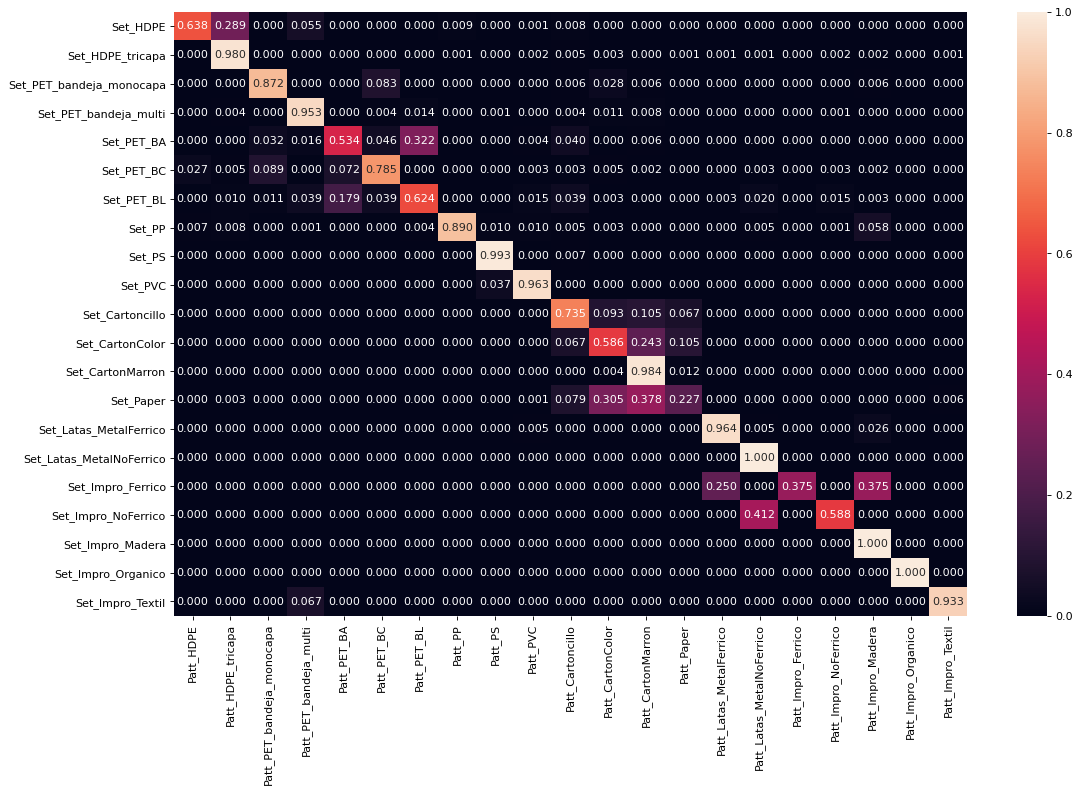

In [71]:
from matplotlib.pyplot import figure

CrossMatrixPer = np.array([ classif_HDPE, classif_HDPE_tricapa, classif_PET_bandeja_monocapa, classif_PET_bandeja_multi,
                           classif_PET_BA, classif_PET_BC, classif_PET_BL, classif_PP, classif_PS, classif_PVC, classif_Cartoncillo,
                           classif_CartonColor, classif_CartonMarron, classif_Paper, classif_MetalFerrico, classif_MetalNoFerrico,
                           classif_Impro_Ferrico, classif_Impro_NoFerrico, classif_Impro_Madera, classif_Impro_Organico,classif_Impro_Textil])

CrossMatrixPer = CrossMatrixPer.astype('float64')

CrossMatrixPer[0]=(CrossMatrixPer[0]/CrossMatrixPer[0].sum()).round(decimals=3)
CrossMatrixPer[1]=(CrossMatrixPer[1]/CrossMatrixPer[1].sum()).round(decimals=3)
CrossMatrixPer[2]=(CrossMatrixPer[2]/CrossMatrixPer[2].sum()).round(decimals=3)
CrossMatrixPer[3]=(CrossMatrixPer[3]/CrossMatrixPer[3].sum()).round(decimals=3)
CrossMatrixPer[4]=(CrossMatrixPer[4]/CrossMatrixPer[4].sum()).round(decimals=3)
CrossMatrixPer[5]=(CrossMatrixPer[5]/CrossMatrixPer[5].sum()).round(decimals=3)
CrossMatrixPer[6]=(CrossMatrixPer[6]/CrossMatrixPer[6].sum()).round(decimals=3)
CrossMatrixPer[7]=(CrossMatrixPer[7]/CrossMatrixPer[7].sum()).round(decimals=3)
CrossMatrixPer[8]=(CrossMatrixPer[8]/CrossMatrixPer[8].sum()).round(decimals=3)
CrossMatrixPer[9]=(CrossMatrixPer[9]/CrossMatrixPer[9].sum()).round(decimals=3)
CrossMatrixPer[10]=(CrossMatrixPer[10]/CrossMatrixPer[10].sum()).round(decimals=3)
CrossMatrixPer[11]=(CrossMatrixPer[11]/CrossMatrixPer[11].sum()).round(decimals=3)
CrossMatrixPer[12]=(CrossMatrixPer[12]/CrossMatrixPer[12].sum()).round(decimals=3)
CrossMatrixPer[13]=(CrossMatrixPer[13]/CrossMatrixPer[13].sum()).round(decimals=3)
CrossMatrixPer[14]=(CrossMatrixPer[14]/CrossMatrixPer[14].sum()).round(decimals=3)
CrossMatrixPer[15]=(CrossMatrixPer[15]/CrossMatrixPer[15].sum()).round(decimals=3)
CrossMatrixPer[16]=(CrossMatrixPer[16]/CrossMatrixPer[16].sum()).round(decimals=3)
CrossMatrixPer[17]=(CrossMatrixPer[17]/CrossMatrixPer[17].sum()).round(decimals=3)
CrossMatrixPer[18]=(CrossMatrixPer[18]/CrossMatrixPer[18].sum()).round(decimals=3)
CrossMatrixPer[19]=(CrossMatrixPer[19]/CrossMatrixPer[19].sum()).round(decimals=3)
CrossMatrixPer[20]=(CrossMatrixPer[20]/CrossMatrixPer[20].sum()).round(decimals=3)

dfCM = pd.DataFrame(CrossMatrixPer)
dfCM.index = ['Set_HDPE', 'Set_HDPE_tricapa', 'Set_PET_bandeja_monocapa', 'Set_PET_bandeja_multi',
              'Set_PET_BA', 'Set_PET_BC', 'Set_PET_BL', 'Set_PP', 'Set_PS', 'Set_PVC', 'Set_Cartoncillo',
              'Set_CartonColor', 'Set_CartonMarron', 'Set_Paper', 'Set_Latas_MetalFerrico', 'Set_Latas_MetalNoFerrico',
              'Set_Impro_Ferrico', 'Set_Impro_NoFerrico', 'Set_Impro_Madera', 'Set_Impro_Organico','Set_Impro_Textil']
dfCM.columns=['Patt_HDPE', 'Patt_HDPE_tricapa', 'Patt_PET_bandeja_monocapa', 'Patt_PET_bandeja_multi',
              'Patt_PET_BA', 'Patt_PET_BC', 'Patt_PET_BL', 'Patt_PP', 'Patt_PS', 'Patt_PVC', 'Patt_Cartoncillo',
              'Patt_CartonColor', 'Patt_CartonMarron', 'Patt_Paper', 'Patt_Latas_MetalFerrico', 'Patt_Latas_MetalNoFerrico',
              'Patt_Impro_Ferrico', 'Patt_Impro_NoFerrico', 'Patt_Impro_Madera', 'Patt_Impro_Organico','Patt_Impro_Textil']

figure(figsize=(16, 10), dpi=80)
sns.heatmap(dfCM, annot = True,fmt='.3f')

    

Se agrupan los resultados por conceptos y muestra la matriz de confusión resultante:

* **HDPE** --> HDPE y HDPE_tricapa
* **PET** --> PET_bandeja_monocapa, PET_bandeja_multi, classif_PET_BA, classif_PET_BC y classif_PET_BL
* **PP** --> PP
* **PS** --> PS
* **PVC** --> PVC
* **Carton** --> Cartoncillo, CartonColor, CartonMarron, Paper
* **MetalFerrico** --> Latas_MetalFerrico y Impro_Ferrico
* **MetalNoFerrico** --> Latas_MetalNoFerrico y Impro_NoFerrico
* **Impro_Madera** --> Impro_Madera
* **Impro_Organico** --> Impro_Organico
* **Impro_Textil** --> Impro_Textil

<AxesSubplot:>

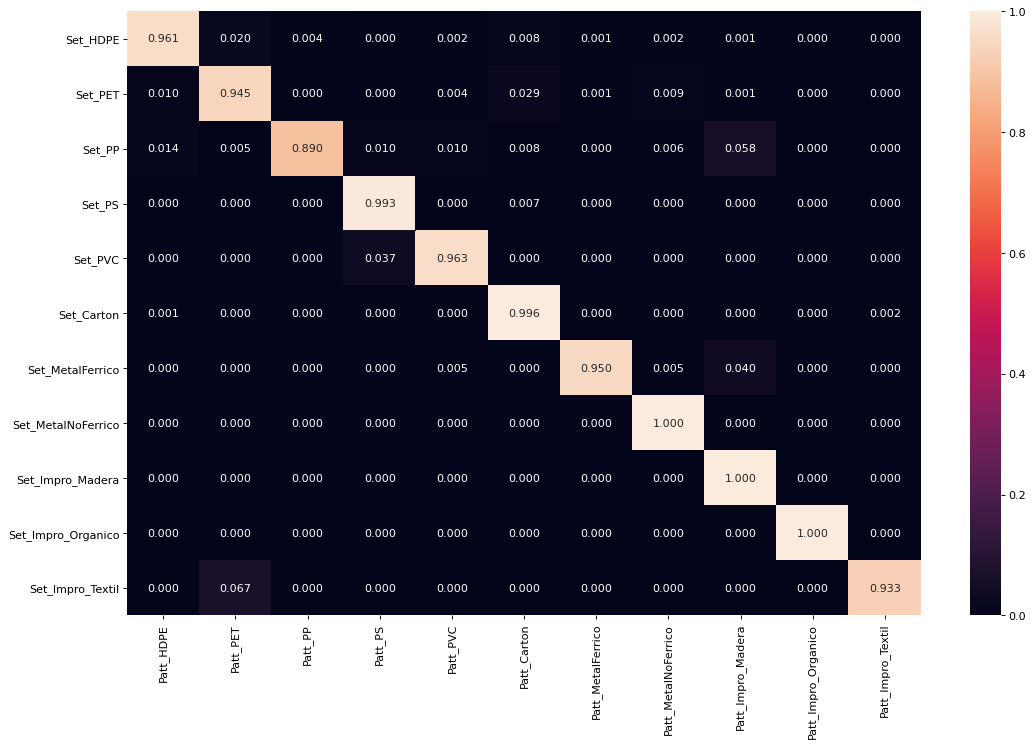

In [72]:
from matplotlib.pyplot import figure

#CrossMatrixPer = np.array([classif_HDPE,classif_PET,classif_PP,classif_PS,classif_PVC,classif_Paper])

CrossMatrixPer = np.array([ classif_HDPE, classif_HDPE_tricapa, classif_PET_bandeja_monocapa, classif_PET_bandeja_multi,
                           classif_PET_BA, classif_PET_BC, classif_PET_BL, classif_PP, classif_PS, classif_PVC, classif_Cartoncillo,
                           classif_CartonColor, classif_CartonMarron, classif_Paper, classif_MetalFerrico, classif_MetalNoFerrico,
                           classif_Impro_Ferrico, classif_Impro_NoFerrico, classif_Impro_Madera, classif_Impro_Organico,classif_Impro_Textil])

CrossMatrixPer = CrossMatrixPer.astype('float64')

# Unifica HDPE y HDPE_tricapa en una sola clase HDPE
CrossMatrixPer[:,0] = CrossMatrixPer[:,0] +CrossMatrixPer[:,1]
CrossMatrixPer = np.delete(CrossMatrixPer,1,1)
CrossMatrixPer[0,:] = CrossMatrixPer[0,:] +CrossMatrixPer[1,:]
CrossMatrixPer = np.delete(CrossMatrixPer,1,0)

# Unifica classif_PET_bandeja_monocapa, classif_PET_bandeja_multi,classif_PET_BA, classif_PET_BC y classif_PET_BL en una sola clase PET
CrossMatrixPer[:,1] = CrossMatrixPer[:,1]+CrossMatrixPer[:,2]+CrossMatrixPer[:,3]+CrossMatrixPer[:,4]+CrossMatrixPer[:,5]
CrossMatrixPer = np.delete(CrossMatrixPer,[2,3,4,5],1)
CrossMatrixPer[1,:] = CrossMatrixPer[1,:]+CrossMatrixPer[2,:]+CrossMatrixPer[3,:]+CrossMatrixPer[4,:]+CrossMatrixPer[5,:]
CrossMatrixPer = np.delete(CrossMatrixPer,[2,3,4,5],0)

# Unifica Cartoncillo, CartonColor, CartonMarron y Paper en una sola clase "Carton"
CrossMatrixPer[:,5] = CrossMatrixPer[:,5]+CrossMatrixPer[:,6]+CrossMatrixPer[:,7]+CrossMatrixPer[:,8]
CrossMatrixPer = np.delete(CrossMatrixPer,[6,7,8],1)
CrossMatrixPer[5,:] = CrossMatrixPer[5,:]+CrossMatrixPer[6,:]+CrossMatrixPer[7,:]+CrossMatrixPer[8,:]
CrossMatrixPer = np.delete(CrossMatrixPer,[6,7,8],0)

# Unifica classif_MetalFerrico y classif_Impro_Ferrico en una sola clase "Ferrico"
CrossMatrixPer[:,6] = CrossMatrixPer[:,6]+CrossMatrixPer[:,8]
CrossMatrixPer = np.delete(CrossMatrixPer,[8],1)
CrossMatrixPer[6,:] = CrossMatrixPer[6,:]+CrossMatrixPer[8,:]
CrossMatrixPer = np.delete(CrossMatrixPer,[8],0)

# Unifica classif_MetalNoFerrico y classif_Impro_NoFerrico en una sola clase "NoFerrico"
CrossMatrixPer[:,7] = CrossMatrixPer[:,7]+CrossMatrixPer[:,8]
CrossMatrixPer = np.delete(CrossMatrixPer,[8],1)
CrossMatrixPer[7,:] = CrossMatrixPer[7,:]+CrossMatrixPer[8,:]
CrossMatrixPer = np.delete(CrossMatrixPer,[8],0)

CrossMatrixPer[0]=CrossMatrixPer[0]/CrossMatrixPer[0].sum().round(decimals=2)
CrossMatrixPer[1]=CrossMatrixPer[1]/CrossMatrixPer[1].sum().round(decimals=2)
CrossMatrixPer[2]=CrossMatrixPer[2]/CrossMatrixPer[2].sum().round(decimals=2)
CrossMatrixPer[3]=CrossMatrixPer[3]/CrossMatrixPer[3].sum().round(decimals=2)
CrossMatrixPer[4]=CrossMatrixPer[4]/CrossMatrixPer[4].sum().round(decimals=2)
CrossMatrixPer[5]=CrossMatrixPer[5]/CrossMatrixPer[5].sum().round(decimals=2)
CrossMatrixPer[6]=CrossMatrixPer[6]/CrossMatrixPer[6].sum().round(decimals=2)
CrossMatrixPer[7]=CrossMatrixPer[7]/CrossMatrixPer[7].sum().round(decimals=2)
CrossMatrixPer[8]=CrossMatrixPer[8]/CrossMatrixPer[8].sum().round(decimals=2)
CrossMatrixPer[9]=CrossMatrixPer[9]/CrossMatrixPer[9].sum().round(decimals=2)
CrossMatrixPer[10]=CrossMatrixPer[10]/CrossMatrixPer[10].sum().round(decimals=2)
dfCM = pd.DataFrame(CrossMatrixPer)

dfCM.index = ['Set_HDPE', 'Set_PET', 'Set_PP', 'Set_PS', 'Set_PVC', 'Set_Carton', 'Set_MetalFerrico', 'Set_MetalNoFerrico',
              'Set_Impro_Madera', 'Set_Impro_Organico','Set_Impro_Textil']
dfCM.columns=['Patt_HDPE', 'Patt_PET', 'Patt_PP', 'Patt_PS', 'Patt_PVC', 'Patt_Carton', 'Patt_MetalFerrico', 'Patt_MetalNoFerrico',
              'Patt_Impro_Madera', 'Patt_Impro_Organico','Patt_Impro_Textil']

figure(figsize=(16, 10), dpi=80)
sns.heatmap(dfCM, annot = True,fmt='.3f')

Funcion auxiliar grava imagenes con la segmentación de los objetos contenidos en un dataset de acuerdo con los resultados obtenidos del modelo. Cada color corresponde con un modelo de acuerdo con la agrupación anterior.

In [ ]:
from tqdm.notebook import tqdm  #mostra la barra s'estat
import numpy as np
import pandas as pd
import pickle
import cv2
import os

Colors = [[85,85,85],[255,0,0],[0,255,0],[0,0,255],[255,255,0],[255,0,255],
          [0,255,255],[255,127,39],[195,195,195],[140,0,0],[0,140,0],[0,140,140]]

# import Model from disc ############################################################################
sourceData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\07_DATASET__MODELS\03_Patterns_SVM"
filename = 'model_SVM.sav'
model_SVM = pickle.load(open(os.path.join(sourceData,filename), 'rb'))

# Read image from dfFile ###########################################################################

#sourceData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\03_DATASET_Normalization"
sourceData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\06_DATASET_TESTING"
OutData = r"C:\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\08_DATASET_COLORING"

sourceData = r"C:\\Users\jrosell\Hyperspectral\___PFM___\01_DATASET\03_DATASET_Normalization"
fileDataSet = r"blobs_002_09_produccion_09_bis.csv"
filePaleta = 'Paleta_LR.png'

imgPaleta = cv2.imread(filePaleta)
dataBlobs= pd.read_csv(os.path.join(sourceData,fileDataSet), sep='\t')

groups= dataBlobs.groupby(["image"]) #Imagen + blob
keys = groups.groups.keys()

for idx, key in enumerate(tqdm(keys)):    
    img = np.zeros([96, 320 ,3]).astype(np.uint8)    
    data = groups.get_group(key)    
    idx0 = data.columns.get_loc('0')
    predClass = model_SVM.predict(data.iloc[:,idx0:(idx0+224)])
    for i in range(len(data)):
        y = int(data.iloc[i,2])
        x = int(data.iloc[i,3])

        if predClass[i]=='1' or predClass[i]=='2':
            idxGrouped =1
        elif predClass[i]=='3' or predClass[i]=='4' or predClass[i]=='5' or predClass[i]=='6' or predClass[i]=='7':
            idxGrouped =2
        elif predClass[i]=='8':
            idxGrouped =3
        elif predClass[i]=='9':
            idxGrouped =4
        elif predClass[i]=='10':
            idxGrouped =5
        elif predClass[i]=='11' or predClass[i]=='12' or predClass[i]=='13' or predClass[i]=='14':
            idxGrouped =6
        elif predClass[i]=='15' or predClass[i]=='17':
            idxGrouped =7
        elif predClass[i]=='16' or predClass[i]=='18':
            idxGrouped =8
        elif predClass[i]=='19':
            idxGrouped =9        
        elif predClass[i]=='20':
            idxGrouped =10
        elif predClass[i]=='21':
            idxGrouped =11
        else: 
            idxGrouped =0
            
        img[y,x]=Colors[idxGrouped]  
        
    imgOut=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_v = cv2.hconcat([imgOut, imgPaleta])
    cv2.imwrite(os.path.join(OutData,"img_"+str(idx)+".png"),im_v)
